# LSTM System Identification: Newell-Lee Evaporator

In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler

import keras
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model,load_model

## Load the Data Set

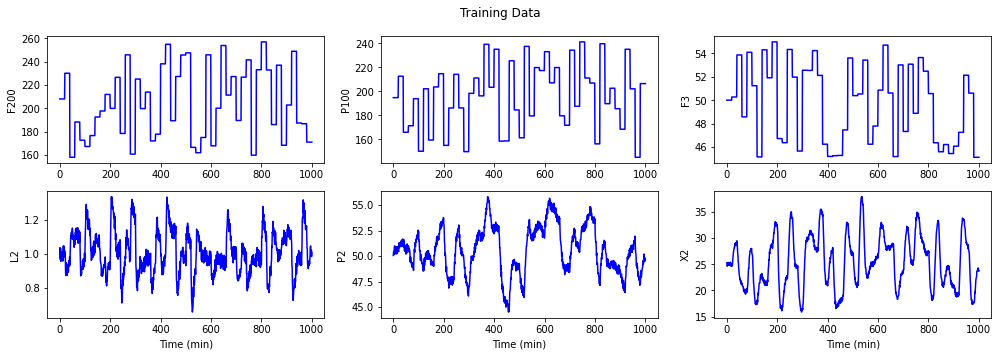

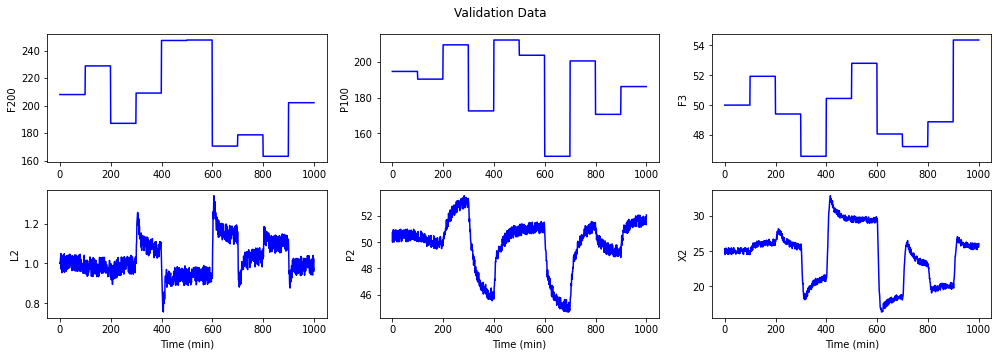

(1001, 6)
(1001, 6)


In [3]:
evap_df = pd.read_csv('evap_seed1.csv', index_col=0)
evap_df2 = pd.read_csv('evap_seed3_valid.csv', index_col=0)

v_name = ['F200', 'P100', 'F3', 'L2', 'P2', 'X2']
noise_var = np.array([0, 0, 0, 0.1, 1, 1])

np.random.seed(0)

def prepare_and_plot(evap_df, noise_var, label):
    plt.figure(figsize=(14, 5))
    timepts = np.linspace(0, 1000, 1001)
    ctr = 1
    res = list()
    for j in range(len(v_name)):
        plt.subplot(2, 3, ctr)
        data = np.interp(timepts, evap_df.index.values, evap_df[v_name[j]].values)
        data += (np.random.rand(len(data))-0.5)*noise_var[j]
        res.append(data)
        plt.plot(data, 'b')
        plt.ylabel(v_name[j])
        if j > 2:
            plt.xlabel('Time (min)')
        ctr += 1

    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    
    return np.transpose(np.vstack(res))

Z_train = prepare_and_plot(evap_df, noise_var, 'Training Data')
Z_valid = prepare_and_plot(evap_df2, noise_var, 'Validation Data')
print(Z_train.shape)
print(Z_valid.shape)

In [4]:
YI, UI = np.array([3, 4, 5]), np.array([0, 1, 2])

sc = StandardScaler()
Z_train_sc = sc.fit_transform(Z_train)
Z_valid_sc = sc.transform(Z_valid)

# LSTM Input:  Both [u_k, y_(k-1)] data for time steps k := [k, k+look_back-1]
# LSTM Output: Only [y_k] data for time steps k := [k, k+look_back-1]

look_back = 15
UY_train, Y_train = [], []
UY_valid, Y_valid = [], []

for k in range(1, len(Z_train)-look_back+1):
    UY_train.append(np.hstack((Z_train_sc[k:k+look_back, UI], 
                               Z_train_sc[k-1:k+look_back-1, YI])))
    Y_train.append(Z_train_sc[k:k+look_back, YI])
                    
    UY_valid.append(np.hstack((Z_valid_sc[k:k+look_back, UI], 
                               Z_valid_sc[k-1:k+look_back-1, YI])))
    Y_valid.append(Z_valid_sc[k:k+look_back, YI])

UY_train_ = np.stack(UY_train, axis=0)
Y_train_ = np.stack(Y_train, axis=0)
UY_valid_ = np.stack(UY_valid, axis=0)
Y_valid_ = np.stack(Y_valid, axis=0)

print(sc.scale_)
print(sc.mean_)

print(UY_train_.shape)
print(Y_train_.shape)
print(UY_valid_.shape)
print(Y_valid_.shape)

[30.52634951 27.30680801  3.31043849  0.12226375  2.27643356  4.95861316]
[204.82968912 196.14955658  49.74290531   1.0075573   50.58551774
  25.41497448]
(986, 15, 6)
(986, 15, 3)
(986, 15, 6)
(986, 15, 3)


## Make a trial LSTM then evaluate

Ident time: 11.25 sec


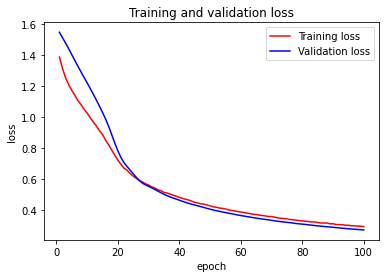

In [25]:
keras.utils.set_random_seed(42)

start = time()
model = Sequential()

reg_value = 0.01
model.add(LSTM(15,
               activation='relu',
               kernel_regularizer=l2(reg_value), 
               recurrent_regularizer=l2(reg_value), 
               bias_regularizer=l2(reg_value),
               dropout=0.2,
               recurrent_dropout=0.2,
               return_sequences=True))
model.add(Dense(3, 
                activation='linear',
                kernel_regularizer=l2(reg_value),
                bias_regularizer=l2(reg_value)))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(UY_train_, Y_train_,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.1, 
                    verbose=0)

print(f'Ident time: {time() - start:.2f} sec')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

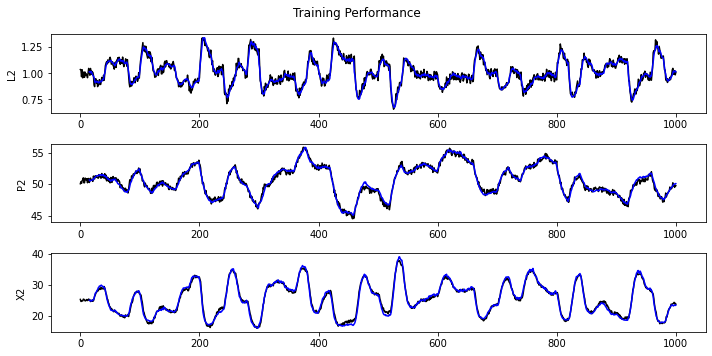

Training Performance: 
 L2 fitness: 92.429%
 P2 fitness: 97.368%
 X2 fitness: 98.408%
 Average:    96.069%
 Sim time:   0.16 sec


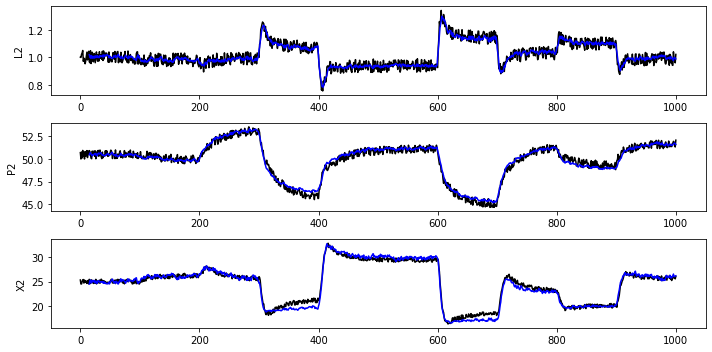

 L2 fitness: 86.283%
 P2 fitness: 96.490%
 X2 fitness: 97.189%
 Average:    93.321%
 Sim time:   0.14 sec


In [28]:
def R2_score(Z, y_pred):
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z[look_back:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)
    return r2

start = time()
y = model.predict(UY_train_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

# Plot for Training Data
plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_train)), Z_train[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+3])
    #plt.xlim([0, 200])

plt.suptitle('Training Performance')
plt.tight_layout()
plt.show()

r2 = R2_score(Z_train, y_)
print('Training Performance: ')
print(f" L2 fitness: {r2[0]*100:.3f}%")
print(f" P2 fitness: {r2[1]*100:.3f}%")
print(f" X2 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

# Plot for Validation Data
start = time()
y = model.predict(UY_valid_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+3])
    #plt.xlim([0, 200])

plt.tight_layout()
plt.show()

r2 = R2_score(Z_valid, y_)
print(f" L2 fitness: {r2[0]*100:.3f}%")
print(f" P2 fitness: {r2[1]*100:.3f}%")
print(f" X2 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

## Use Optuna to tune an LSTM

In [29]:
def create_model(trial):
    
    keras.utils.set_random_seed(42)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
    activation = trial.suggest_categorical("lstm_activation", ["tanh", "linear", "relu"])
    batchsize = trial.suggest_int("batchsize", 3, 8, step=1, log=False) # 2^3 to 2^8
    rec_dropout = trial.suggest_float("rec_dropout", 0, 0.5, step=0.1)
    dropout = trial.suggest_float("dropout", 0, 0.5, step=0.1)
    lstm_units = trial.suggest_int("lstm_units", 5, 40, step=1)
    reg_value = trial.suggest_float("reg_value", 0.01, 1, log=True)
    
    start = time()
    model = Sequential()
    model.add(LSTM(units=lstm_units,
                   activation=activation,
                   kernel_regularizer=l2(reg_value), 
                   recurrent_regularizer=l2(reg_value), 
                   bias_regularizer=l2(reg_value),
                   dropout=dropout,
                   recurrent_dropout=rec_dropout,
                   return_sequences=True))
    model.add(Dense(3, 
                    activation='linear',
                    kernel_regularizer=l2(reg_value),
                    bias_regularizer=l2(reg_value)))
    model.compile(optimizer=optimizer_name, loss='mean_squared_error')
    history = model.fit(UY_train_, Y_train_, 
                        epochs=100,
                        batch_size=2**batchsize,
                        validation_split=0.1,
                        verbose=0)
    
    print(f'Ident time: {time() - start:.2f} sec')
    
    if trial.should_prune():
            raise optuna.TrialPruned()
    
    return model

def objective(trial):
    
    model = create_model(trial)
    
    sim_time = time()
    y = model.predict(UY_valid_, verbose=0)
    y_pred = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
    sim_time = time() - sim_time
    print(f" Sim time:   {sim_time:.2f} sec")
    
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z_valid[look_back:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)   
    
    return np.mean(r2)

sampler = TPESampler(seed=42)
best_mdl, best_study = [], []
study = optuna.create_study(direction='maximize', 
                            sampler=sampler)
optuna_start = time()
study.optimize(lambda trial: objective(trial), n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)
total_time = time()-optuna_start
print("Runtime: %.4f sec" % total_time)

[I 2024-09-25 12:40:51,989] A new study created in memory with name: no-name-bd740313-a570-47af-b2f4-84592ce1303a


Ident time: 9.00 sec


[I 2024-09-25 12:41:01,480] Trial 0 finished with value: -0.08046814862131657 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.30000000000000004, 'dropout': 0.4, 'lstm_units': 5, 'reg_value': 0.8706020878304853}. Best is trial 0 with value: -0.08046814862131657.


 Sim time:   0.36 sec
Ident time: 44.01 sec


[I 2024-09-25 12:41:45,887] Trial 1 finished with value: 0.8762347871253496 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 15, 'reg_value': 0.05404103854647329}. Best is trial 1 with value: 0.8762347871253496.


 Sim time:   0.37 sec
Ident time: 33.86 sec


[I 2024-09-25 12:42:20,043] Trial 2 finished with value: -0.08356418457185073 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.5, 'lstm_units': 39, 'reg_value': 0.4138040112561014}. Best is trial 1 with value: 0.8762347871253496.


 Sim time:   0.28 sec
Ident time: 10.25 sec


[I 2024-09-25 12:42:30,687] Trial 3 finished with value: 0.7941889932649272 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.30000000000000004, 'lstm_units': 16, 'reg_value': 0.10968217207529521}. Best is trial 1 with value: 0.8762347871253496.


 Sim time:   0.38 sec
Ident time: 8.67 sec


[I 2024-09-25 12:42:39,902] Trial 4 finished with value: 0.7785897503232292 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 6, 'reg_value': 0.04473636174621265}. Best is trial 1 with value: 0.8762347871253496.


 Sim time:   0.53 sec
Ident time: 11.36 sec


[I 2024-09-25 12:42:51,560] Trial 5 finished with value: 0.906047065942726 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.5, 'lstm_units': 32, 'reg_value': 0.024970737145052727}. Best is trial 5 with value: 0.906047065942726.


 Sim time:   0.27 sec
Ident time: 80.39 sec


[I 2024-09-25 12:44:12,290] Trial 6 finished with value: 0.9115994274339707 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'tanh', 'batchsize': 3, 'rec_dropout': 0.5, 'dropout': 0.30000000000000004, 'lstm_units': 16, 'reg_value': 0.0134003672433548}. Best is trial 6 with value: 0.9115994274339707.


 Sim time:   0.33 sec
Ident time: 13.65 sec


[I 2024-09-25 12:44:26,334] Trial 7 finished with value: 0.7112819198988071 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 7, 'rec_dropout': 0.4, 'dropout': 0.30000000000000004, 'lstm_units': 32, 'reg_value': 0.09718319944817398}. Best is trial 6 with value: 0.9115994274339707.


 Sim time:   0.38 sec
Ident time: 17.08 sec


[I 2024-09-25 12:44:43,751] Trial 8 finished with value: 0.6361243219010705 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.5, 'dropout': 0.1, 'lstm_units': 19, 'reg_value': 0.3244160088734159}. Best is trial 6 with value: 0.9115994274339707.


 Sim time:   0.32 sec
Ident time: 14.93 sec


[I 2024-09-25 12:44:59,131] Trial 9 finished with value: 0.7109706068530243 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 37, 'reg_value': 0.1198628179990118}. Best is trial 6 with value: 0.9115994274339707.


 Sim time:   0.44 sec
Ident time: 92.23 sec


[I 2024-09-25 12:46:31,809] Trial 10 finished with value: 0.19271407887496794 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'relu', 'batchsize': 3, 'rec_dropout': 0.5, 'dropout': 0.2, 'lstm_units': 25, 'reg_value': 0.01072283950221737}. Best is trial 6 with value: 0.9115994274339707.


 Sim time:   0.37 sec
Ident time: 18.47 sec


[I 2024-09-25 12:46:50,768] Trial 11 finished with value: 0.9285683774289352 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.5, 'lstm_units': 27, 'reg_value': 0.011657335780160467}. Best is trial 11 with value: 0.9285683774289352.


 Sim time:   0.39 sec
Ident time: 28.03 sec


[I 2024-09-25 12:47:19,287] Trial 12 finished with value: 0.9138208083759384 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'tanh', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 25, 'reg_value': 0.013447784829428645}. Best is trial 11 with value: 0.9285683774289352.


 Sim time:   0.43 sec
Ident time: 30.81 sec


[I 2024-09-25 12:47:50,578] Trial 13 finished with value: 0.9281165054614035 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 26, 'reg_value': 0.01870527641455989}. Best is trial 11 with value: 0.9285683774289352.


 Sim time:   0.43 sec
Ident time: 29.22 sec


[I 2024-09-25 12:48:20,226] Trial 14 finished with value: 0.9151630046408985 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 30, 'reg_value': 0.023782920303888715}. Best is trial 11 with value: 0.9285683774289352.


 Sim time:   0.39 sec
Ident time: 18.91 sec


[I 2024-09-25 12:48:39,626] Trial 15 finished with value: -0.27398235297455237 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.5, 'lstm_units': 28, 'reg_value': 0.022542306251875557}. Best is trial 11 with value: 0.9285683774289352.


 Sim time:   0.45 sec
Ident time: 26.23 sec


[I 2024-09-25 12:49:06,306] Trial 16 finished with value: 0.9361295841205566 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.1, 'dropout': 0.4, 'lstm_units': 22, 'reg_value': 0.010519095028133847}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.39 sec
Ident time: 18.56 sec


[I 2024-09-25 12:49:25,297] Trial 17 finished with value: 0.9287246413234196 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.5, 'lstm_units': 20, 'reg_value': 0.010412183718539548}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.38 sec
Ident time: 47.36 sec


[I 2024-09-25 12:50:13,078] Trial 18 finished with value: 0.9330486512362436 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.1, 'dropout': 0.4, 'lstm_units': 20, 'reg_value': 0.010625721497327491}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.38 sec
Ident time: 45.85 sec


[I 2024-09-25 12:50:59,366] Trial 19 finished with value: 0.9161746083844483 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.1, 'dropout': 0.2, 'lstm_units': 10, 'reg_value': 0.03603086451237455}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.39 sec
Ident time: 46.19 sec


[I 2024-09-25 12:51:46,023] Trial 20 finished with value: 0.025149665896207745 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.1, 'dropout': 0.4, 'lstm_units': 21, 'reg_value': 0.01722693994422326}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.43 sec
Ident time: 27.88 sec


[I 2024-09-25 12:52:14,362] Trial 21 finished with value: 0.9194981550031045 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.1, 'dropout': 0.5, 'lstm_units': 21, 'reg_value': 0.010426894161316605}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.42 sec
Ident time: 9.64 sec


[I 2024-09-25 12:52:24,367] Trial 22 finished with value: 0.8831528466287174 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.4, 'lstm_units': 12, 'reg_value': 0.016793231038248247}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.33 sec
Ident time: 17.88 sec


[I 2024-09-25 12:52:42,693] Trial 23 finished with value: 0.9352891497424783 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.30000000000000004, 'lstm_units': 20, 'reg_value': 0.010549744050522118}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.41 sec
Ident time: 26.78 sec


[I 2024-09-25 12:53:09,911] Trial 24 finished with value: 0.9148740733530767 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.30000000000000004, 'lstm_units': 23, 'reg_value': 0.028200609975773446}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.40 sec
Ident time: 60.64 sec


[I 2024-09-25 12:54:10,972] Trial 25 finished with value: 0.9298023155748539 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 3, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 18, 'reg_value': 0.016131937212459545}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.38 sec
Ident time: 44.48 sec


[I 2024-09-25 12:54:55,928] Trial 26 finished with value: 0.9106699721715262 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.1, 'dropout': 0.30000000000000004, 'lstm_units': 12, 'reg_value': 0.031820961858316184}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.42 sec
Ident time: 18.29 sec


[I 2024-09-25 12:55:14,662] Trial 27 finished with value: 0.9081192903271446 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.4, 'lstm_units': 23, 'reg_value': 0.01712329007475521}. Best is trial 16 with value: 0.9361295841205566.


 Sim time:   0.38 sec
Ident time: 26.23 sec


[I 2024-09-25 12:55:41,295] Trial 28 finished with value: 0.9375780848034755 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.1, 'dropout': 0.30000000000000004, 'lstm_units': 14, 'reg_value': 0.01048792832736113}. Best is trial 28 with value: 0.9375780848034755.


 Sim time:   0.36 sec
Ident time: 11.70 sec


[I 2024-09-25 12:55:53,459] Trial 29 finished with value: 0.9146963835788314 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 8, 'reg_value': 0.0211451712862996}. Best is trial 28 with value: 0.9375780848034755.


 Sim time:   0.42 sec
Ident time: 20.24 sec


[I 2024-09-25 12:56:14,069] Trial 30 finished with value: 0.933080286996311 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.0, 'dropout': 0.30000000000000004, 'lstm_units': 13, 'reg_value': 0.013911606572916482}. Best is trial 28 with value: 0.9375780848034755.


 Sim time:   0.33 sec
Ident time: 19.50 sec


[I 2024-09-25 12:56:33,962] Trial 31 finished with value: 0.9330063200896214 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.0, 'dropout': 0.30000000000000004, 'lstm_units': 13, 'reg_value': 0.013981435510047662}. Best is trial 28 with value: 0.9375780848034755.


 Sim time:   0.34 sec
Ident time: 19.35 sec


[I 2024-09-25 12:56:53,656] Trial 32 finished with value: 0.938056809679214 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.0, 'dropout': 0.30000000000000004, 'lstm_units': 15, 'reg_value': 0.01005458270356263}. Best is trial 32 with value: 0.938056809679214.


 Sim time:   0.30 sec
Ident time: 17.08 sec


[I 2024-09-25 12:57:11,186] Trial 33 finished with value: 0.9393315086982551 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.2, 'lstm_units': 17, 'reg_value': 0.010320038832587712}. Best is trial 33 with value: 0.9393315086982551.


 Sim time:   0.39 sec
Ident time: 18.28 sec


[I 2024-09-25 12:57:29,857] Trial 34 finished with value: 0.9401393330018436 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 17, 'reg_value': 0.019282553148875607}. Best is trial 34 with value: 0.9401393330018436.


 Sim time:   0.34 sec
Ident time: 31.68 sec


[I 2024-09-25 12:58:01,908] Trial 35 finished with value: 0.9404437863123523 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 17, 'reg_value': 0.020983974327708006}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.32 sec
Ident time: 30.79 sec


[I 2024-09-25 12:58:33,020] Trial 36 finished with value: 0.9222144341579509 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.03890033310897413}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.27 sec
Ident time: 31.01 sec


[I 2024-09-25 12:59:04,381] Trial 37 finished with value: 0.9378818073465888 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.02796754949082869}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.31 sec
Ident time: 30.97 sec


[I 2024-09-25 12:59:35,698] Trial 38 finished with value: 0.93819795675938 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 9, 'reg_value': 0.02200418909311711}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.30 sec
Ident time: 51.39 sec


[I 2024-09-25 13:00:27,412] Trial 39 finished with value: 0.8762437858078066 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 5, 'reg_value': 0.058725147478336855}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.28 sec
Ident time: 38.03 sec


[I 2024-09-25 13:01:06,012] Trial 40 finished with value: 0.8939788225914761 and parameters: {'optimizer': 'adam', 'lstm_activation': 'tanh', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 9, 'reg_value': 0.021524598968620478}. Best is trial 35 with value: 0.9404437863123523.


 Sim time:   0.53 sec
Ident time: 31.28 sec


[I 2024-09-25 13:01:37,657] Trial 41 finished with value: 0.9407223843385193 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 17, 'reg_value': 0.01985415401400573}. Best is trial 41 with value: 0.9407223843385193.


 Sim time:   0.31 sec
Ident time: 55.18 sec


[I 2024-09-25 13:02:33,207] Trial 42 finished with value: 0.93370691332068 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 17, 'reg_value': 0.026750696087778632}. Best is trial 41 with value: 0.9407223843385193.


 Sim time:   0.33 sec
Ident time: 30.58 sec


[I 2024-09-25 13:03:04,156] Trial 43 finished with value: 0.9388751038687527 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 10, 'reg_value': 0.01996521454877019}. Best is trial 41 with value: 0.9407223843385193.


 Sim time:   0.32 sec
Ident time: 31.21 sec


[I 2024-09-25 13:03:35,733] Trial 44 finished with value: 0.9422635700875549 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 11, 'reg_value': 0.013831044407427584}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.32 sec
Ident time: 81.80 sec


[I 2024-09-25 13:04:57,970] Trial 45 finished with value: 0.9378896566352942 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 16, 'reg_value': 0.014322829809623641}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.40 sec
Ident time: 37.20 sec


[I 2024-09-25 13:05:35,810] Trial 46 finished with value: 0.9266588630028676 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 18, 'reg_value': 0.013443285595938692}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.59 sec
Ident time: 12.07 sec


[I 2024-09-25 13:05:48,205] Trial 47 finished with value: 0.888328357027719 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 7, 'reg_value': 0.04803429071888989}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.28 sec
Ident time: 76.80 sec


[I 2024-09-25 13:07:05,431] Trial 48 finished with value: 0.9402765265986628 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 11, 'reg_value': 0.018332698951900747}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.39 sec
Ident time: 52.97 sec


[I 2024-09-25 13:07:58,754] Trial 49 finished with value: 0.08497839848095556 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 11, 'reg_value': 0.018910431973559974}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.31 sec
Ident time: 72.11 sec


[I 2024-09-25 13:09:11,321] Trial 50 finished with value: 0.930311915800318 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 38, 'reg_value': 0.03263149229152837}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.41 sec
Ident time: 14.10 sec


[I 2024-09-25 13:09:25,976] Trial 51 finished with value: 0.9408101859261712 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.015319331395038494}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.49 sec
Ident time: 12.38 sec


[I 2024-09-25 13:09:38,951] Trial 52 finished with value: 0.9344978828528543 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 15, 'reg_value': 0.025026238667150112}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.53 sec
Ident time: 13.59 sec


[I 2024-09-25 13:09:53,116] Trial 53 finished with value: 0.9415562367940832 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 14, 'reg_value': 0.01671195911570429}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.50 sec
Ident time: 14.67 sec


[I 2024-09-25 13:10:08,420] Trial 54 finished with value: 0.9385741084585462 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.01512167143365939}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.55 sec
Ident time: 11.35 sec


[I 2024-09-25 13:10:20,211] Trial 55 finished with value: 0.9171874593176934 and parameters: {'optimizer': 'adam', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.012829362735710918}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.36 sec
Ident time: 13.09 sec


[I 2024-09-25 13:10:33,725] Trial 56 finished with value: 0.9404865164915931 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.01595448179193276}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.39 sec
Ident time: 12.22 sec


[I 2024-09-25 13:10:46,366] Trial 57 finished with value: 0.9419209869150947 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.30000000000000004, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.012464268794585693}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.38 sec
Ident time: 12.41 sec


[I 2024-09-25 13:10:59,207] Trial 58 finished with value: -0.03784420382979359 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.30000000000000004, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.01245677492565913}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.39 sec
Ident time: 13.72 sec


[I 2024-09-25 13:11:13,398] Trial 59 finished with value: 0.9398495128470533 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.015967731579482527}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.40 sec
Ident time: 11.24 sec


[I 2024-09-25 13:11:25,019] Trial 60 finished with value: 0.9122099014746546 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 7, 'rec_dropout': 0.30000000000000004, 'dropout': 0.1, 'lstm_units': 7, 'reg_value': 0.01229042911968174}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.33 sec
Ident time: 12.29 sec


[I 2024-09-25 13:11:37,762] Trial 61 finished with value: 0.939627330659215 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.30000000000000004, 'dropout': 0.1, 'lstm_units': 13, 'reg_value': 0.015555205833763876}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.41 sec
Ident time: 12.47 sec


[I 2024-09-25 13:11:50,655] Trial 62 finished with value: 0.9308043689037616 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 15, 'reg_value': 0.024042874243766926}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.37 sec
Ident time: 10.64 sec


[I 2024-09-25 13:12:01,729] Trial 63 finished with value: 0.9382490063878275 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 19, 'reg_value': 0.016877856805100722}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.38 sec
Ident time: 10.07 sec


[I 2024-09-25 13:12:12,196] Trial 64 finished with value: 0.9314451985080967 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 11, 'reg_value': 0.012644073405087141}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.35 sec
Ident time: 12.32 sec


[I 2024-09-25 13:12:24,927] Trial 65 finished with value: 0.9371839192771217 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 14, 'reg_value': 0.021338416591347806}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.37 sec
Ident time: 13.33 sec


[I 2024-09-25 13:12:38,695] Trial 66 finished with value: 0.9379945072208903 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.30000000000000004, 'dropout': 0.2, 'lstm_units': 19, 'reg_value': 0.014966433994314412}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.38 sec
Ident time: 16.05 sec


[I 2024-09-25 13:12:55,205] Trial 67 finished with value: 0.9419014065080434 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.012123131382550383}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.41 sec
Ident time: 16.71 sec


[I 2024-09-25 13:13:12,350] Trial 68 finished with value: -1.2876928042196956 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 9, 'reg_value': 0.017768210778778045}. Best is trial 44 with value: 0.9422635700875549.


 Sim time:   0.39 sec
Ident time: 12.04 sec


[I 2024-09-25 13:13:24,779] Trial 69 finished with value: 0.9428051589838696 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.011730406885068552}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.34 sec
Ident time: 16.92 sec


[I 2024-09-25 13:13:42,184] Trial 70 finished with value: 0.9410606140715614 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.011862569468067527}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.40 sec
Ident time: 16.22 sec


[I 2024-09-25 13:13:58,864] Trial 71 finished with value: 0.9411033895070374 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.011733104818516582}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.41 sec
Ident time: 16.44 sec


[I 2024-09-25 13:14:15,708] Trial 72 finished with value: 0.9410976175005322 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.01175103061220836}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.35 sec
Ident time: 17.55 sec


[I 2024-09-25 13:14:33,702] Trial 73 finished with value: 0.9411358998014556 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.011631509554177251}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.38 sec
Ident time: 16.06 sec


[I 2024-09-25 13:14:50,220] Trial 74 finished with value: 0.9357935622830915 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 8, 'reg_value': 0.012467425739808073}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.39 sec
Ident time: 16.73 sec


[I 2024-09-25 13:15:07,420] Trial 75 finished with value: 0.937383546912088 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 11, 'reg_value': 0.011404391970273552}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.42 sec
Ident time: 16.13 sec


[I 2024-09-25 13:15:23,916] Trial 76 finished with value: 0.9367384441035028 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 10, 'reg_value': 0.011475641311632383}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.32 sec
Ident time: 16.79 sec


[I 2024-09-25 13:15:41,054] Trial 77 finished with value: 0.9415771490520832 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 13, 'reg_value': 0.013808039944006747}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.30 sec
Ident time: 16.34 sec


[I 2024-09-25 13:15:57,853] Trial 78 finished with value: 0.9411043713772417 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 13, 'reg_value': 0.013646394170335667}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.40 sec
Ident time: 16.38 sec


[I 2024-09-25 13:16:14,670] Trial 79 finished with value: -0.09367331750558794 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 13, 'reg_value': 0.01347371978751464}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.39 sec
Ident time: 15.87 sec


[I 2024-09-25 13:16:30,996] Trial 80 finished with value: 0.9401267070302163 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 10, 'reg_value': 0.014546491788196204}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.38 sec
Ident time: 16.03 sec


[I 2024-09-25 13:16:47,454] Trial 81 finished with value: 0.9415881910920806 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.010523957068357192}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.36 sec
Ident time: 17.24 sec


[I 2024-09-25 13:17:05,130] Trial 82 finished with value: 0.941745222770045 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 15, 'reg_value': 0.010232411552216865}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.37 sec
Ident time: 16.64 sec


[I 2024-09-25 13:17:22,218] Trial 83 finished with value: 0.9417732546358332 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 15, 'reg_value': 0.010011431282500823}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.40 sec
Ident time: 17.37 sec


[I 2024-09-25 13:17:40,028] Trial 84 finished with value: 0.9421113709949477 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.010265102942938644}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.39 sec
Ident time: 16.02 sec


[I 2024-09-25 13:17:56,483] Trial 85 finished with value: 0.9421048305180774 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.010576517591067165}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.38 sec
Ident time: 25.87 sec


[I 2024-09-25 13:18:22,812] Trial 86 finished with value: 0.9416973486761092 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.01000113013758629}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.40 sec
Ident time: 25.94 sec


[I 2024-09-25 13:18:49,170] Trial 87 finished with value: 0.9417584682272557 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.011433945710466638}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.36 sec
Ident time: 25.41 sec


[I 2024-09-25 13:19:15,052] Trial 88 finished with value: 0.9417207368144459 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 16, 'reg_value': 0.010200158077542472}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.41 sec
Ident time: 25.57 sec


[I 2024-09-25 13:19:40,961] Trial 89 finished with value: 0.9421165129818622 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.010001437014756422}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.27 sec
Ident time: 27.50 sec


[I 2024-09-25 13:20:08,896] Trial 90 finished with value: 0.9415968501510026 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.5, 'dropout': 0.0, 'lstm_units': 21, 'reg_value': 0.011279907236023354}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.39 sec
Ident time: 25.96 sec


[I 2024-09-25 13:20:35,303] Trial 91 finished with value: 0.9422026261091369 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 15, 'reg_value': 0.010152517525854375}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.39 sec
Ident time: 25.67 sec


[I 2024-09-25 13:21:01,369] Trial 92 finished with value: 0.9418875526679447 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.013003068820885132}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.35 sec
Ident time: 26.22 sec


[I 2024-09-25 13:21:28,059] Trial 93 finished with value: 0.9418525846190567 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.01317826848750004}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.42 sec
Ident time: 25.14 sec


[I 2024-09-25 13:21:53,614] Trial 94 finished with value: 0.9414558480707907 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 20, 'reg_value': 0.012878523932020729}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.36 sec
Ident time: 27.07 sec


[I 2024-09-25 13:22:21,060] Trial 95 finished with value: 0.938897370914218 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.018350607521042797}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.33 sec
Ident time: 27.45 sec


[I 2024-09-25 13:22:48,977] Trial 96 finished with value: 0.9410428428415152 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 25, 'reg_value': 0.014505569593737321}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.42 sec
Ident time: 26.03 sec


[I 2024-09-25 13:23:15,449] Trial 97 finished with value: 0.9412349618363769 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 22, 'reg_value': 0.013413081049595883}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.37 sec
Ident time: 25.41 sec


[I 2024-09-25 13:23:41,265] Trial 98 finished with value: 0.9396320684686472 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 5, 'rec_dropout': 0.5, 'dropout': 0.0, 'lstm_units': 17, 'reg_value': 0.016775557146228248}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.36 sec
Ident time: 27.05 sec


[I 2024-09-25 13:24:08,727] Trial 99 finished with value: 0.9264753661357208 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 5, 'rec_dropout': 0.4, 'dropout': 0.0, 'lstm_units': 18, 'reg_value': 0.014982282716408155}. Best is trial 69 with value: 0.9428051589838696.


 Sim time:   0.36 sec


Best parameters:  {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 12, 'reg_value': 0.011730406885068552}
Runtime: 2596.7356 sec


## Evaluate the performance of the best model

Ident time: 11.81 sec


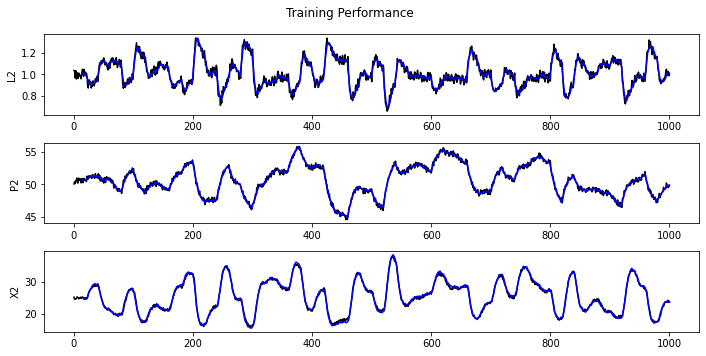

Training Performance: 
 L2 fitness: 92.815%
 P2 fitness: 98.096%
 X2 fitness: 99.115%
 Average:    96.675%
 Sim time:   0.32 sec


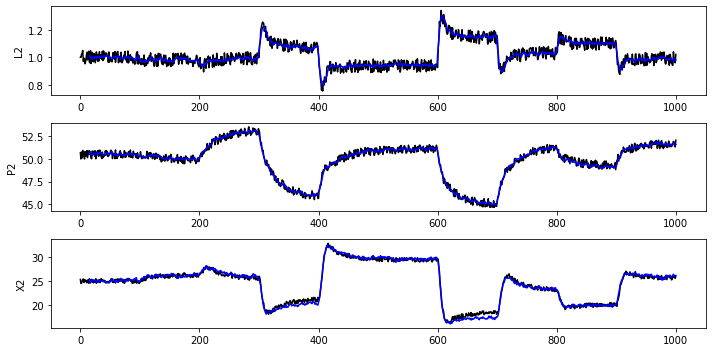

 L2 fitness: 86.827%
 P2 fitness: 97.628%
 X2 fitness: 98.387%
 Average:    94.281%
 Sim time:   0.14 sec


In [30]:
best_mdl = create_model(study.best_trial)

start = time()
y = best_mdl.predict(UY_train_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

# Plot for Training Data
plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_train)), Z_train[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+3])
    #plt.xlim([0, 200])

plt.suptitle('Training Performance')
plt.tight_layout()
plt.show()

r2 = R2_score(Z_train, y_)
print('Training Performance: ')
print(f" L2 fitness: {r2[0]*100:.3f}%")
print(f" P2 fitness: {r2[1]*100:.3f}%")
print(f" X2 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

# Plot for Validation Data
start = time()
y = best_mdl.predict(UY_valid_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+3])
    #plt.xlim([0, 200])

plt.tight_layout()
plt.show()

r2 = R2_score(Z_valid, y_)
print(f" L2 fitness: {r2[0]*100:.3f}%")
print(f" P2 fitness: {r2[1]*100:.3f}%")
print(f" X2 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

In [31]:
best_mdl.save('evap_lstm.keras')

## Check the performance of LSTM for infinite-step ahead prediction

In [14]:
def R2_score_(Z, y_pred):
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z[:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)
    return r2

In [16]:
best_mdl = load_model('evap_lstm.keras')

uy0 = np.array((208, 194.7, 50, 1, 50.5, 25)*look_back).reshape(-1, 6)
noise = (np.random.rand(look_back, len(YI))-0.5)*np.array([0.1, 1, 1])
uy0[:, YI] = uy0[:, YI] + noise
u = Z_valid[:, UI]

def sim_mpc(lstm_mdl, uy0, u):
    # Shape of uy0: [look_back x n_u+n_y] (not scaled)
    # Shape of u:   [N_hor x n_u] (not scaled)
    
    # u includes the initial state u0

    N = u.shape[0] # This is N_hor
    y_pred = np.zeros((N, len(YI)))
    uy = (uy0 - sc.mean_) / sc.scale_
    u_ = (u - sc.mean_[UI]) / sc.scale_[UI]
    y_pred[0, :] = uy[-1, YI]
    
    for j in np.arange(1, N):
        uy = np.hstack((np.vstack((uy[1:, UI], 
                                   u_[np.minimum(j, N), :])), 
                        uy[:, YI]))
        y = lstm_mdl.predict(uy[np.newaxis, :, :], verbose=0)
        y_pred[j, :] = y[:, -1, :]
        uy = np.hstack((uy[:, UI],
                        np.vstack((uy[1:, YI], y[:, -1, :]))))
    
    y_pred = y_pred * sc.scale_[YI] + sc.mean_[YI]
    
    return y_pred

start = time()
y_pred = sim_mpc(best_mdl, uy0, u)
sim_time = time() - start
print(y_pred.shape)
print(f"Sim Time: {sim_time:.2f} sec")

(1001, 3)
Sim Time: 60.32 sec


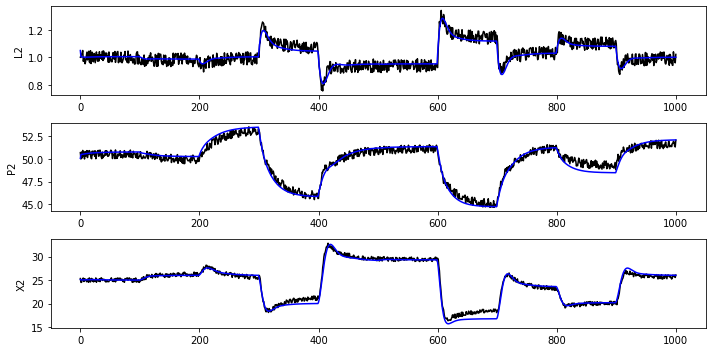

 L2 fitness: 84.320%
 P2 fitness: 94.415%
 X2 fitness: 97.446%
 Average:    92.060%
 Sim time:   60.32 sec


In [17]:
# Plot for Validation Data

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(range(len(Z_valid)), y_pred[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+3])
    #plt.xlim([0, 2])

plt.tight_layout()
plt.show()

r2 = R2_score_(Z_valid, y_pred)
print(f" L2 fitness: {r2[0]*100:.3f}%")
print(f" P2 fitness: {r2[1]*100:.3f}%")
print(f" X2 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")